In [1]:
import pandas as pd
import numpy as np
import math
from sqlalchemy import create_engine
import pickle

In [2]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [3]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [4]:
query = "SELECT * FROM whole_data_table"
data = pd.read_sql(query, con=engine)

# 分析データの確認

In [5]:
from matplotlib import pyplot as plt

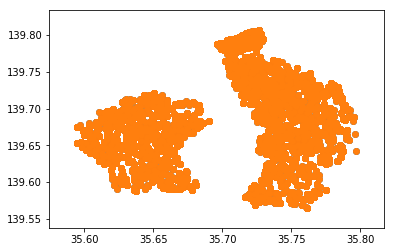

In [7]:
plt.scatter(data.address_lat, data.latitude_lng)
plt.show()

In [14]:
import pickle
with open('../../gci_project_storage/analytical_data.pickle', mode='rb') as f:
     analytical_data = pickle.load(f)

In [18]:
analytical_data = analytical_data.reindex(np.random.permutation(analytical_data.index))

In [19]:
X = analytical_data.iloc[:,1:]
y = analytical_data.iloc[:,:1]

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

model_r = RandomForestRegressor(n_estimators=100)
#model_l = LinearRegression()

model_r.fit(X.iloc[:20000,:],y.iloc[:20000,:])
#model_l.fit(X,y)

print(model_r.score(X.iloc[20000:,:],y.iloc[20000:,:]))
#model_l.score(X,y)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.896236167972


In [ ]:
list_n_estimators = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,200,300,500]
list_scores = []
for n_est in list_n_estimators:
    model_r = RandomForestRegressor(n_estimators=n_est)
    model_r.fit(X.iloc[:20000,:],y.iloc[:20000,:])
    list_scores.append(model_r.score(X.iloc[20000:,:],y.iloc[20000:,:]))
plt.plot(list_n_estimators,list_scores,'b')
plt.show()
list_scores

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


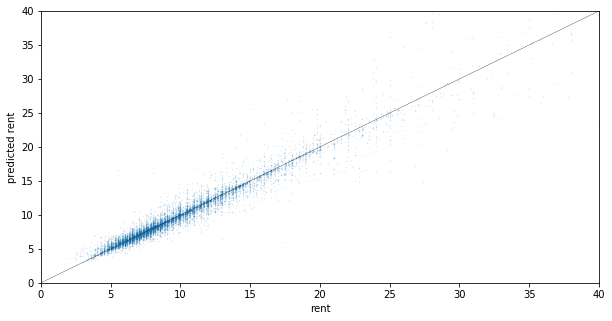

In [66]:
plt.figure(figsize=(10,5))

y_pred = model_r.predict(X)
plt.scatter(x=y.rent[20000:],y=y_pred[20000:],s=0.1,alpha=0.2)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("rent")
plt.ylabel("predicted rent")
plt.plot([0,40],[0,40],c="black",linewidth=0.3)
plt.show()

In [39]:
y.rent.sort_values()[30000:]

21349     24.0
17745     24.0
30188     24.0
23133     24.0
23451     24.0
15939     24.0
19821     24.0
22359     24.0
31385     24.0
17516     24.0
15640     24.0
12947     24.0
3481      24.0
17542     24.0
21555     24.0
18531     24.0
17727     24.0
21557     24.0
17079     24.0
21943     24.0
13093     24.1
4327      24.1
3608      24.1
1771      24.1
405       24.1
19605     24.1
26222     24.1
13588     24.1
24974     24.2
27082     24.2
         ...  
25840     70.0
24778     74.9
25759     79.0
25658     80.0
25958     84.0
25959     84.0
24857     85.0
17214     85.0
25012     90.0
25222    100.0
25901    100.0
23878    110.0
25605    110.0
27190    110.0
26624    115.0
17965    115.0
16555    115.0
24454    115.0
22081    120.0
17859    120.0
26874    125.0
25895    135.0
24084    138.0
25883    140.0
25792    140.0
27376    150.0
25892    160.0
23879    175.0
26729    210.0
25882    220.0
Name: rent, Length: 728, dtype: float64

In [28]:
?plt.scatter